<a href="https://colab.research.google.com/github/AnkurMali/IST597_Spring_2022/blob/main/IST597_MLP_collab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IST597:- Multi-Layer Perceptron

# Case 1: 

Using default batch size without softmax activation in output layer, without any regularization to determine the Categorical Cross-Entropy of test dataset and determine the accuracy of default model in GPU,TPU,CPU and on default mode.

## Load the libraries

In [ ]:
#Core Libraries 
import os
import numpy as np
import time
import tensorflow as tf
#Libraries for data featching
from sklearn.datasets import fetch_openml
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
np.random.seed(5997)
tf.random.set_seed(5997)

In [ ]:
x, y = fetch_openml('mnist_784', version=1, return_X_y=True)
x = (x/255).astype('float32')
y = to_categorical(y)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#Get number of Gpu's and id's in the system or else you can also use Nvidia-smi in command prompt.

## Define the input layer size, hidden layers size and output layer size

In [ ]:
size_input = 784
size_hidden = [128,64]
size_output = 10
number_of_train_examples = 60000
number_of_test_examples = 10000

In [ ]:
# Split dataset into batches
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(16)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(4)

## Build MLP using Eager Execution

In [ ]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden, self.size_output, self.device =\
    size_input, size_hidden, size_output, device
    
    # Initialize weights between input layer and hidden layer-1
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden[0]]))
    # Initialize biases for hidden layer-1
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden[0]]))

    # Initialize weights between hidden layer-1 and hidden layer-2
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden[0], self.size_hidden[1]]))
    # Initialize biases for hidden layer-1
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden[1]]))

     # Initialize weights between hidden layer and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden[1], self.size_output]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
    
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.keras.losses.CategoricalCrossentropy()(y_true_tf, y_pred_tf)
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
        
        
  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer1
    what1 = tf.matmul(X_tf, self.W1) + self.b1
    hhat1 = tf.nn.relu(what1)
    # Compute values in hidden layer2
    what2 = tf.matmul(hhat1, self.W2) + self.b2
    hhat2 = tf.nn.relu(what2)
    # Compute output
    output = tf.matmul(hhat2, self.W3) + self.b3
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

## Train Model

In [ ]:
# Set number of epochs
NUM_EPOCHS = 10

In [ ]:
# Initialize model using CPU
mlp_on_cpu = MLP(size_input, size_hidden, size_output, device='cpu')

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  accuracy_a = tf.zeros([], dtype=tf.float32) #tensor for accumulating accuracy
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=epoch*(5997)).batch(20)
  for inputs, outputs in train_ds:
    # Calculate accuracy
    preds = mlp_on_cpu.forward(inputs)
    pred = tf.nn.softmax(preds)
    outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
    pred = tf.cast(pred, dtype=tf.float32)
    correct_prediction = tf.equal(tf.argmax(outputs, 1), tf.argmax(pred, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))



    accuracy_a = accuracy_a + accuracy
    loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)
    lt = lt + mlp_on_cpu.loss(preds, outputs)
    mlp_on_cpu.backward(inputs, outputs)
  print('Number of Epoch = {} - Categorical_Cross-Entropy:= {}'.format(epoch + 1, np.sum(loss_total) / x_train.shape[0]))
  print('Number of Epoch = {} - Accuracy:= {}'.format(epoch + 1, (np.sum(accuracy_a) / x_train.shape[0])*100))
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs

Number of Epoch = 1 - Categorical_Cross-Entropy:= 0.2540452337184874
Number of Epoch = 1 - Accuracy:= 0.4616836163176208
Number of Epoch = 2 - Categorical_Cross-Entropy:= 0.247548959427521
Number of Epoch = 2 - Accuracy:= 0.4713471741235557
Number of Epoch = 3 - Categorical_Cross-Entropy:= 0.24297213103991597
Number of Epoch = 3 - Accuracy:= 0.4810948988970588
Number of Epoch = 4 - Categorical_Cross-Entropy:= 0.2380863149947479
Number of Epoch = 4 - Accuracy:= 0.4897495814732143
Number of Epoch = 5 - Categorical_Cross-Entropy:= 0.22200520286239495
Number of Epoch = 5 - Accuracy:= 0.5048750164128152
Number of Epoch = 6 - Categorical_Cross-Entropy:= 0.20988084296218487
Number of Epoch = 6 - Accuracy:= 0.503530704273897
Number of Epoch = 7 - Categorical_Cross-Entropy:= 0.1993276162027311
Number of Epoch = 7 - Accuracy:= 0.5033629858193277
Number of Epoch = 8 - Categorical_Cross-Entropy:= 0.19061667870273108
Number of Epoch = 8 - Accuracy:= 0.5072281524914654
Number of Epoch = 9 - Categori

In [ ]:
# Initialize model using GPU
mlp_on_gpu = MLP(size_input, size_hidden, size_output, device='gpu')

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  accuracy_a = tf.zeros([], dtype=tf.float32) #tensor for accumulating accuracy
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=epoch*(5997)).batch(20)
  for inputs, outputs in train_ds:
    preds = mlp_on_gpu.forward(inputs)
    pred = tf.nn.softmax(preds)


    outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
    pred = tf.cast(pred, dtype=tf.float32)

    correct_prediction = tf.equal(tf.argmax(outputs, 1), tf.argmax(pred, 1))
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))



    accuracy_a = accuracy_a + accuracy
    loss_total_gpu = loss_total_gpu + mlp_on_gpu.loss(preds, outputs)
    lt = lt + mlp_on_gpu.loss(preds, outputs)
    mlp_on_gpu.backward(inputs, outputs)
  print('Number of Epoch = {} - Categorical Cross-Entropy:= {}'.format(epoch + 1, np.sum(loss_total_gpu) / x_train.shape[0]))
  print('Number of Epoch = {} - Accuracy:= {}'.format(epoch + 1, (np.sum(accuracy_a) / x_train.shape[0])*100))
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

Number of Epoch = 1 - Categorical Cross-Entropy:= 0.42788383009453784
Number of Epoch = 1 - Accuracy:= 0.52899226340927
Number of Epoch = 2 - Categorical Cross-Entropy:= 0.4151001181722689
Number of Epoch = 2 - Accuracy:= 0.5319335424599527
Number of Epoch = 3 - Categorical Cross-Entropy:= 0.3966051404936975
Number of Epoch = 3 - Accuracy:= 0.549749191668855
Number of Epoch = 4 - Categorical Cross-Entropy:= 0.36249474789915964
Number of Epoch = 4 - Accuracy:= 0.5327742889147846
Number of Epoch = 5 - Categorical Cross-Entropy:= 0.34080225840336137
Number of Epoch = 5 - Accuracy:= 0.5390756302521008
Number of Epoch = 6 - Categorical Cross-Entropy:= 0.32490342699579833
Number of Epoch = 6 - Accuracy:= 0.5627730169216124
Number of Epoch = 7 - Categorical Cross-Entropy:= 0.3074765625
Number of Epoch = 7 - Accuracy:= 0.6010082597492121
Number of Epoch = 8 - Categorical Cross-Entropy:= 0.2927140887605042
Number of Epoch = 8 - Accuracy:= 0.6168062610786502
Number of Epoch = 9 - Categorical Cro

In [ ]:
#Default mode
mlp_on_default = MLP(size_input, size_hidden, size_output)

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  accuracy_a = tf.zeros([], dtype=tf.float32)
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=epoch*(5997)).batch(150)
  for inputs, outputs in train_ds:
    preds = mlp_on_default.forward(inputs)
    pred = tf.nn.softmax(preds)  # Applying softmax to logits to get better accuracy


    outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
    pred = tf.cast(pred, dtype=tf.float32)

    correct_prediction = tf.equal(tf.argmax(outputs, 1), tf.argmax(pred, 1))
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))



    accuracy_a = accuracy_a + accuracy
    loss_total_gpu = loss_total_gpu + mlp_on_default.loss(preds, outputs)
    lt = lt + mlp_on_default.loss(preds, outputs)
    mlp_on_default.backward(inputs, outputs)
  print('Number of Epoch = {} - Categorical Cross-Entropy:= {}'.format(epoch + 1, np.sum(loss_total_gpu) / x_train.shape[0]))
  print('Number of Epoch = {} - Accuracy:= {}'.format(epoch + 1, (np.sum(accuracy_a) / x_train.shape[0])*1000))
time_taken = time.time() - time_start
print('\n')
print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

Number of Epoch = 1 - Categorical Cross-Entropy:= 0.029009708180147056
Number of Epoch = 1 - Accuracy:= 0.5672555426589581
Number of Epoch = 2 - Categorical Cross-Entropy:= 0.02849617171087185
Number of Epoch = 2 - Accuracy:= 0.5738382881228663
Number of Epoch = 3 - Categorical Cross-Entropy:= 0.0281072003019958
Number of Epoch = 3 - Accuracy:= 0.5773509367614233
Number of Epoch = 4 - Categorical Cross-Entropy:= 0.027478581276260506
Number of Epoch = 4 - Accuracy:= 0.5914010697052258
Number of Epoch = 5 - Categorical Cross-Entropy:= 0.02647882336528361
Number of Epoch = 5 - Accuracy:= 0.5989332154859014
Number of Epoch = 6 - Categorical Cross-Entropy:= 0.0253718938747374
Number of Epoch = 6 - Accuracy:= 0.59819054983443573
Number of Epoch = 7 - Categorical Cross-Entropy:= 0.02454001444327731
Number of Epoch = 7 - Accuracy:= 0.6128578904095819
Number of Epoch = 8 - Categorical Cross-Entropy:= 0.023555405560661765
Number of Epoch = 8 - Accuracy:= 0.61438934459526
Number of Epoch = 9 - Ca

In [ ]:
test_loss_total = tf.Variable(0, dtype=tf.float32)
accuracy_a = tf.zeros([], dtype=tf.float32)
#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlp_on_default.forward(inputs)

  pred = preds
  outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
  pred = tf.cast(pred, dtype=tf.float32)

  correct_prediction = tf.equal(tf.argmax(outputs, 1), tf.argmax(pred, 1))
  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  accuracy_a = accuracy_a + accuracy
  #b = mlp_on_default.loss(preds, outputs)
  test_loss_total = test_loss_total + mlp_on_default.loss(preds, outputs)
# a = (test_loss_total.numpy() / X_train.shape[0])
# print(X_train.shape[0])
# print(test_loss_total.numpy())
# print(b)
print('Test Categorical_Cross-Entropy: {:.4f}'.format(np.sum(test_loss_total.numpy()) / x_train.shape[0]))
print('Test Accuracy: {:.4f}'.format((np.sum(accuracy_a) / x_train.shape[0])*100))

Test Categorical_Cross-Entropy: 0.0785
Test Accuracy: 0.6142


## Plot

In [15]:
acc = [0.56725,0.57383,0.57735,0.59140,0.59893,0.59819,0.61285,0.61438,0.61851,0.62098]

In [16]:
loss = [0.02900,0.02849,0.02849,0.02747,0.02647,0.02537,0.02454,0.02355,0.02241,0.02157]

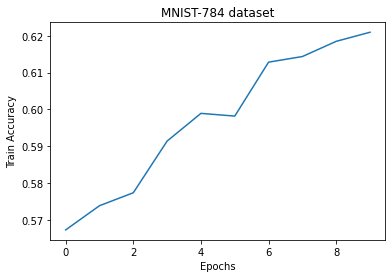

In [4]:
from matplotlib import pyplot as plt
plt.xlabel('Epochs')
plt.ylabel('Train Accuracy')
plt.title('MNIST-784 dataset')
plt.plot(acc)
# plt.plot(loss)

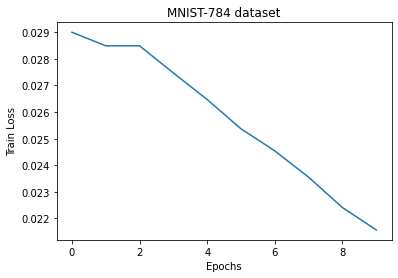

In [17]:
from matplotlib import pyplot as plt
plt.xlabel('Epochs')
plt.ylabel('Train Loss')
plt.title('MNIST-784 dataset')
plt.plot(loss)

### Test values for 10 rounds

In [7]:
acct = [60.37, 56.23, 58.81, 55.41, 58.45, 54.99, 56.86, 61.25, 59.34, 57.56]

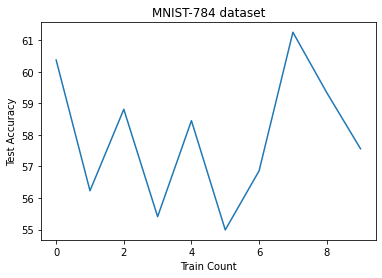

In [9]:
from matplotlib import pyplot as plt
plt.xlabel('Train Count')
plt.ylabel('Test Accuracy')
plt.title('MNIST-784 dataset')
plt.plot(acct)
# plt.plot(loss)

# Case 2

In this case, the implementation is done using an additional layer of softmax on the top of the output layer. Softmax will Using default batch size with softmax activation in output layer, without any regularization. Softmax predict a multinomial probability distribution. That is, softmax is used as the activation function for multi-class classification problems where class membership is required on more than two class labels.

In [ ]:
# Split dataset into batches
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(16)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(4)

In [ ]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden, self.size_output, self.device =\
    size_input, size_hidden, size_output, device
    
    # Initialize weights between input layer and hidden layer-1
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden[0]]))
    # Initialize biases for hidden layer-1
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden[0]]))

    # Initialize weights between hidden layer-1 and hidden layer-2
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden[0], self.size_hidden[1]]))
    # Initialize biases for hidden layer-1
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden[1]]))

     # Initialize weights between hidden layer and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden[1], self.size_output]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
    
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.keras.losses.CategoricalCrossentropy()(y_true_tf, y_pred_tf)
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
        
        
  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer1
    what1 = tf.matmul(X_tf, self.W1) + self.b1
    hhat1 = tf.nn.relu(what1)
    # Compute values in hidden layer2
    what2 = tf.matmul(hhat1, self.W2) + self.b2
    hhat2 = tf.nn.relu(what2)
    # Compute output
    output = tf.matmul(hhat2, self.W3) + self.b3
    output = tf.keras.activations.softmax(output)
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

In [ ]:
# Set number of epochs
NUM_EPOCHS = 10

In [ ]:
#Default mode
mlp_on_default = MLP(size_input, size_hidden, size_output)

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  accuracy_a = tf.zeros([], dtype=tf.float32)
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=epoch*(5997)).batch(20)
  for inputs, outputs in train_ds:
    preds = mlp_on_default.forward(inputs)
    pred = tf.nn.softmax(preds)  # Applying softmax to logits to get better accuracy


    outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
    pred = tf.cast(pred, dtype=tf.float32)

    correct_prediction = tf.equal(tf.argmax(outputs, 1), tf.argmax(pred, 1))
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))



    accuracy_a = accuracy_a + accuracy
    loss_total_gpu = loss_total_gpu + mlp_on_default.loss(preds, outputs)
    lt = lt + mlp_on_default.loss(preds, outputs)
    mlp_on_default.backward(inputs, outputs)
  print('Number of Epoch = {} - Categorical Cross-Entropy:= {}'.format(epoch + 1, np.sum(loss_total_gpu) / x_train.shape[0]))
  print('Number of Epoch = {} - Accuracy:= {}'.format(epoch + 1, (np.sum(accuracy_a) / x_train.shape[0])*100))
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

Number of Epoch = 1 - Categorical Cross-Entropy:= 0.3698112526260504
Number of Epoch = 1 - Accuracy:= 0.489329721146271
Number of Epoch = 2 - Categorical Cross-Entropy:= 0.36060353203781514
Number of Epoch = 2 - Accuracy:= 0.4901695956702994
Number of Epoch = 3 - Categorical Cross-Entropy:= 0.35689374343487396
Number of Epoch = 3 - Accuracy:= 0.49227110277704833
Number of Epoch = 4 - Categorical Cross-Entropy:= 0.3511022518382353
Number of Epoch = 4 - Accuracy:= 0.4957158449317227
Number of Epoch = 5 - Categorical Cross-Entropy:= 0.3463145351890756
Number of Epoch = 5 - Accuracy:= 0.49747996610753675
Number of Epoch = 6 - Categorical Cross-Entropy:= 0.3402994353991597
Number of Epoch = 6 - Accuracy:= 0.49907759978991595
Number of Epoch = 7 - Categorical Cross-Entropy:= 0.3206730895483193
Number of Epoch = 7 - Accuracy:= 0.494287109375
Number of Epoch = 8 - Categorical Cross-Entropy:= 0.310984112394958
Number of Epoch = 8 - Accuracy:= 0.4947912392496061
Number of Epoch = 9 - Categorical

In [ ]:
test_loss_total = tf.Variable(0, dtype=tf.float32)
accuracy_a = tf.zeros([], dtype=tf.float32)
#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlp_on_default.forward(inputs)

  pred = preds
  outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
  pred = tf.cast(pred, dtype=tf.float32)

  correct_prediction = tf.equal(tf.argmax(outputs, 1), tf.argmax(pred, 1))
  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  accuracy_a = accuracy_a + accuracy
  #b = mlp_on_default.loss(preds, outputs)
  test_loss_total = test_loss_total + mlp_on_default.loss(preds, outputs)
# a = (test_loss_total.numpy() / X_train.shape[0])
# print(X_train.shape[0])
# print(test_loss_total.numpy())
# print(b)
print('Test Categorical_Cross-Entropy: {:.4f}'.format(np.sum(test_loss_total.numpy()) / x_train.shape[0]))
print('Test Accuracy: {:.4f}'.format((np.sum(accuracy_a) / x_train.shape[0])*100))

Test Categorical_Cross-Entropy: 0.6273
Test Accuracy: 0.5030


# Case 3

In this case, the implementation is done by adding a dropout layer after every MLP layer. So we have one Dropout penalty/regularization layers added after the activation of layer of each MLP layer.

In [ ]:
# Split dataset into batches
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(16)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(4)

In [ ]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden, self.size_output, self.dropout_layer, self.device =\
    size_input, size_hidden, size_output, tf.keras.layers.Dropout(rate=0.2), device
    
    # Initialize weights between input layer and hidden layer-1
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden[0]]))
    # Initialize biases for hidden layer-1
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden[0]]))

    # Initialize weights between hidden layer-1 and hidden layer-2
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden[0], self.size_hidden[1]]))
    # Initialize biases for hidden layer-1
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden[1]]))

     # Initialize weights between hidden layer and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden[1], self.size_output]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
    
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.keras.losses.CategoricalCrossentropy()(y_true_tf, y_pred_tf)
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
        
        
  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer1
    what1 = tf.matmul(X_tf, self.W1) + self.b1
    hhat1 = tf.nn.relu(what1)
    hhat1 = self.dropout_layer(hhat1)
    # Compute values in hidden layer2
    what2 = tf.matmul(hhat1, self.W2) + self.b2
    hhat2 = tf.nn.relu(what2)
    hhat2 = self.dropout_layer(hhat2)
    # Compute output
    output = tf.matmul(hhat2, self.W3) + self.b3
    #output = tf.keras.activations.softmax(output)
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

In [ ]:
# Set number of epochs
NUM_EPOCHS = 10

In [ ]:
#Default mode
mlp_on_default = MLP(size_input, size_hidden, size_output)

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  accuracy_a = tf.zeros([], dtype=tf.float32) 
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=epoch*(5997)).batch(20)
  for inputs, outputs in train_ds:
    preds = mlp_on_default.forward(inputs)
    pred = tf.nn.softmax(preds)  # Applying softmax to logits to get better accuracy


    outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
    pred = tf.cast(pred, dtype=tf.float32)

    correct_prediction = tf.equal(tf.argmax(outputs, 1), tf.argmax(pred, 1))
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))



    accuracy_a = accuracy_a + accuracy
    loss_total_gpu = loss_total_gpu + mlp_on_default.loss(preds, outputs)
    lt = lt + mlp_on_default.loss(preds, outputs)
    mlp_on_default.backward(inputs, outputs)
  print('Number of Epoch = {} - Categorical Cross-Entropy:= {}'.format(epoch + 1, np.sum(loss_total_gpu) / x_train.shape[0]))
  print('Number of Epoch = {} - Accuracy:= {}'.format(epoch + 1, (np.sum(accuracy_a) / x_train.shape[0])*100))
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

Number of Epoch = 1 - Categorical Cross-Entropy:= 0.08024983587184874
Number of Epoch = 1 - Accuracy:= 0.5735574930655856
Number of Epoch = 2 - Categorical Cross-Entropy:= 0.08018526785714286
Number of Epoch = 2 - Accuracy:= 0.5777403887580422
Number of Epoch = 3 - Categorical Cross-Entropy:= 0.08011497176995798
Number of Epoch = 3 - Accuracy:= 0.582091515805541
Number of Epoch = 4 - Categorical Cross-Entropy:= 0.08004182805934874
Number of Epoch = 4 - Accuracy:= 0.5862928759150144
Number of Epoch = 5 - Categorical Cross-Entropy:= 0.07997803965336134
Number of Epoch = 5 - Accuracy:= 0.5916153723452271
Number of Epoch = 6 - Categorical Cross-Entropy:= 0.07992221966911765
Number of Epoch = 6 - Accuracy:= 0.5951822104574251
Number of Epoch = 7 - Categorical Cross-Entropy:= 0.0798676552652311
Number of Epoch = 7 - Accuracy:= 0.5986182589490874
Number of Epoch = 8 - Categorical Cross-Entropy:= 0.07981012834821428
Number of Epoch = 8 - Accuracy:= 0.6016997008764444
Number of Epoch = 9 - Cate

In [ ]:
test_loss_total = tf.Variable(0, dtype=tf.float32)
accuracy_a = tf.zeros([], dtype=tf.float32)
#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlp_on_default.forward(inputs)

  pred = preds
  outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
  pred = tf.cast(pred, dtype=tf.float32)

  correct_prediction = tf.equal(tf.argmax(outputs, 1), tf.argmax(pred, 1))
  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  accuracy_a = accuracy_a + accuracy
  #b = mlp_on_default.loss(preds, outputs)
  test_loss_total = test_loss_total + mlp_on_default.loss(preds, outputs)
# a = (test_loss_total.numpy() / X_train.shape[0])
# print(X_train.shape[0])
# print(test_loss_total.numpy())
# print(b)
print('Test Categorical_Cross-Entropy: {:.4f}'.format(np.sum(test_loss_total.numpy()) / x_train.shape[0]))
print('Test Accuracy: {:.4f}'.format((np.sum(accuracy_a) / x_train.shape[0])*100))

Test Categorical_Cross-Entropy: 0.1022
Test Accuracy: 0.6028


# Case 4

In this case, the implementation is done by adding regularizing function by applying L1 penalty/regularization.

In [ ]:
# Split dataset into batches
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(16)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(4)

In [ ]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden, self.size_output, self.dropout_layer, self.device =\
    size_input, size_hidden, size_output, tf.keras.layers.Dropout(rate=0.2), device
    
    # Initialize weights between input layer and hidden layer-1
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden[0]]))
    # Initialize biases for hidden layer-1
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden[0]]))

    # Initialize weights between hidden layer-1 and hidden layer-2
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden[0], self.size_hidden[1]]))
    # Initialize biases for hidden layer-1
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden[1]]))

     # Initialize weights between hidden layer and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden[1], self.size_output]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
    
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.keras.losses.CategoricalCrossentropy()(y_true_tf, y_pred_tf)
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      L1= (tf.reduce_sum(self.W1)+ tf.reduce_sum(self.W2)+tf.reduce_sum(self.W3)) # L1 = absolute sum of weights (Also known as Lasso)
      current_loss = self.loss(predicted, y_train) + 0.03 * L1 # Lambda/Regularization Parameter = 0.03
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
        
        
  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer1
    what1 = tf.matmul(X_tf, self.W1) + self.b1
    hhat1 = tf.nn.relu(what1)
    # hhat1 = self.dropout_layer(hhat1)
    # Compute values in hidden layer2
    what2 = tf.matmul(hhat1, self.W2) + self.b2
    hhat2 = tf.nn.relu(what2)
    # hhat2 = self.dropout_layer(hhat2)
    # Compute output
    output = tf.matmul(hhat2, self.W3) + self.b3
    #output = tf.keras.activations.softmax(output)
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

In [ ]:
# Set number of epochs
NUM_EPOCHS = 10

In [ ]:
#Default mode
mlp_on_default = MLP(size_input, size_hidden, size_output)

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  accuracy_a = tf.zeros([], dtype=tf.float32)
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=epoch*(5997)).batch(20)
  for inputs, outputs in train_ds:
    preds = mlp_on_default.forward(inputs)
    pred = tf.nn.softmax(preds)  # Applying softmax to logits to get better accuracy


    outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
    pred = tf.cast(pred, dtype=tf.float32)

    correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(outputs, 1))
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))



    accuracy_a = accuracy_a + accuracy
    loss_total_gpu = loss_total_gpu + mlp_on_default.loss(preds, outputs)
    lt = lt + mlp_on_default.loss(preds, outputs)
    mlp_on_default.backward(inputs, outputs)
  print('Number of Epoch = {} - Categorical Cross-Entropy:= {}'.format(epoch + 1, np.sum(loss_total_gpu) / x_train.shape[0]))
  print('Number of Epoch = {} - Accuracy:= {}'.format(epoch + 1, (np.sum(accuracy_a) / x_train.shape[0])*100))
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

Number of Epoch = 1 - Categorical Cross-Entropy:= 0.039850729549632355
Number of Epoch = 1 - Accuracy:= 0.5931840784409468
Number of Epoch = 2 - Categorical Cross-Entropy:= 0.039683286009716386
Number of Epoch = 2 - Accuracy:= 0.5939121406619289
Number of Epoch = 3 - Categorical Cross-Entropy:= 0.039616063222163864
Number of Epoch = 3 - Accuracy:= 0.5937256372275472
Number of Epoch = 4 - Categorical Cross-Entropy:= 0.03951135356486345
Number of Epoch = 4 - Accuracy:= 0.5935015638335412
Number of Epoch = 5 - Categorical Cross-Entropy:= 0.03922808889180672
Number of Epoch = 5 - Accuracy:= 0.5944726126534599
Number of Epoch = 6 - Categorical Cross-Entropy:= 0.03859858357405462
Number of Epoch = 6 - Accuracy:= 0.5987677694368764
Number of Epoch = 7 - Categorical Cross-Entropy:= 0.03806398946297269
Number of Epoch = 7 - Accuracy:= 0.6019235819327731
Number of Epoch = 8 - Categorical Cross-Entropy:= 0.03746544692095588
Number of Epoch = 8 - Accuracy:= 0.6064985259240415
Number of Epoch = 9 -

In [ ]:
test_loss_total = tf.Variable(0, dtype=tf.float32)
accuracy_a = tf.zeros([], dtype=tf.float32)
#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlp_on_default.forward(inputs)

  pred = preds
  outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
  pred = tf.cast(pred, dtype=tf.float32)

  correct_prediction = tf.equal(tf.argmax(outputs, 1), tf.argmax(pred, 1))
  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  accuracy_a = accuracy_a + accuracy
  #b = mlp_on_default.loss(preds, outputs)
  test_loss_total = test_loss_total + mlp_on_default.loss(preds, outputs)
# a = (test_loss_total.numpy() / X_train.shape[0])
# print(X_train.shape[0])
# print(test_loss_total.numpy())
# print(b)
print('Test Categorical_Cross-Entropy: {:.4f}'.format(np.sum(test_loss_total.numpy()) / x_train.shape[0]))
print('Test Accuracy: {:.4f}'.format((np.sum(accuracy_a) / x_train.shape[0])*100))

Test Categorical_Cross-Entropy: 0.0931
Test Accuracy: 0.6011


# Case 5


In this case, the implementation is done by adding regularizing function by applying L2 penalty/regularization.

In [ ]:
# Split dataset into batches
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(16)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(4)

In [ ]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden, self.size_output, self.dropout_layer, self.device =\
    size_input, size_hidden, size_output, tf.keras.layers.Dropout(rate=0.2), device
    
    # Initialize weights between input layer and hidden layer-1
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden[0]]))
    # Initialize biases for hidden layer-1
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden[0]]))

    # Initialize weights between hidden layer-1 and hidden layer-2
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden[0], self.size_hidden[1]]))
    # Initialize biases for hidden layer-1
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden[1]]))

     # Initialize weights between hidden layer and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden[1], self.size_output]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
    
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.keras.losses.CategoricalCrossentropy()(y_true_tf, y_pred_tf)
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      L2= (tf.reduce_sum(tf.square(self.W1))+ tf.reduce_sum(tf.square(self.W2))+tf.reduce_sum(tf.square(self.W3)))/3 # L2 = (absolute sum of squared weights)/no.of weights (Also known as Lasso)
      current_loss = self.loss(predicted, y_train) + 0.03 * L2 # Lambda/Regularization Parameter = 0.03
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
        
        
  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer1
    what1 = tf.matmul(X_tf, self.W1) + self.b1
    hhat1 = tf.nn.relu(what1)
    # hhat1 = self.dropout_layer(hhat1)
    # Compute values in hidden layer2
    what2 = tf.matmul(hhat1, self.W2) + self.b2
    hhat2 = tf.nn.relu(what2)
    # hhat2 = self.dropout_layer(hhat2)
    # Compute output
    output = tf.matmul(hhat2, self.W3) + self.b3
    #output = tf.keras.activations.softmax(output)
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

In [ ]:
# Set number of epochs
NUM_EPOCHS = 10

In [ ]:
#Default mode
mlp_on_default = MLP(size_input, size_hidden, size_output)

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  accuracy_a = tf.zeros([], dtype=tf.float32) #tensor for accumulating accuracy
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=epoch*(5997)).batch(20)
  for inputs, outputs in train_ds:
    preds = mlp_on_default.forward(inputs)
    pred = tf.nn.softmax(preds)


    outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
    pred = tf.cast(pred, dtype=tf.float32)

    correct_prediction = tf.equal(tf.argmax(outputs, 1), tf.argmax(pred, 1))
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))



    accuracy_a = accuracy_a + accuracy
    loss_total_gpu = loss_total_gpu + mlp_on_default.loss(preds, outputs)
    lt = lt + mlp_on_default.loss(preds, outputs)
    mlp_on_default.backward(inputs, outputs)
  print('Number of Epoch = {} - Categorical Cross-Entropy:= {}'.format(epoch + 1, np.sum(loss_total_gpu) / x_train.shape[0]))
  print('Number of Epoch = {} - Accuracy:= {}'.format(epoch + 1, (np.sum(accuracy_a) / x_train.shape[0])*100))
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

Number of Epoch = 1 - Categorical Cross-Entropy:= 0.30573391544117645
Number of Epoch = 1 - Accuracy:= 0.4708428390887605
Number of Epoch = 2 - Categorical Cross-Entropy:= 0.25576692161239495
Number of Epoch = 2 - Accuracy:= 0.5183211126247373
Number of Epoch = 3 - Categorical Cross-Entropy:= 0.2125008862920168
Number of Epoch = 3 - Accuracy:= 0.5553782743566177
Number of Epoch = 4 - Categorical Cross-Entropy:= 0.18682595850840336
Number of Epoch = 4 - Accuracy:= 0.5611766654904149
Number of Epoch = 5 - Categorical Cross-Entropy:= 0.17022198332457983
Number of Epoch = 5 - Accuracy:= 0.570252234194459
Number of Epoch = 6 - Categorical Cross-Entropy:= 0.15364607405462186
Number of Epoch = 6 - Accuracy:= 0.5889914632845326
Number of Epoch = 7 - Categorical Cross-Entropy:= 0.1418840762867647
Number of Epoch = 7 - Accuracy:= 0.6093281721868434
Number of Epoch = 8 - Categorical Cross-Entropy:= 0.1343160287552521
Number of Epoch = 8 - Accuracy:= 0.6256299443605567
Number of Epoch = 9 - Catego

## Plot

In [10]:
acc = [0.4708428390887605,0.5183211126247373,0.5553782743566177,0.5611766654904149,0.570252234194459,0.5889914632845326,0.6093281721868434,0.6256299443605567,0.6437807740283613,0.6678145721179096]

In [11]:
loss = [0.30573,0.25576,0.21250,0.18682,0.17022,0.15364,0.14188,0.13431,0.12881,0.12338]

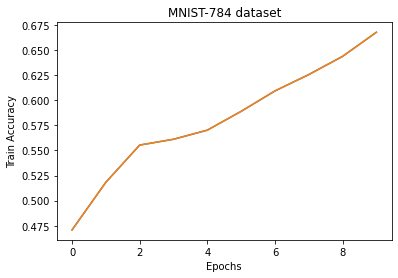

In [12]:
from matplotlib import pyplot as plt
plt.xlabel('Epochs')
plt.ylabel('Train Accuracy')
plt.title('MNIST-784 dataset')
plt.plot(acc)
plt.plot(acc)
# plt.plot(loss)

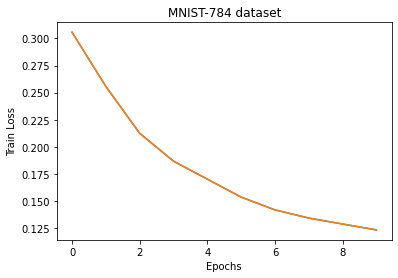

In [14]:
plt.xlabel('Epochs')
plt.ylabel('Train Loss')
plt.title('MNIST-784 dataset')
plt.plot(loss)
plt.plot(loss)

# Case 6

In this case, the implementation is done by adding regularizing function by applying a combination of l1 and l2 penalty/regularization which is called Elastic Net Regularization.

In [ ]:
# Split dataset into batches
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(16)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(4)

In [ ]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden, self.size_output, self.dropout_layer, self.device =\
    size_input, size_hidden, size_output, tf.keras.layers.Dropout(rate=0.2), device
    
    # Initialize weights between input layer and hidden layer-1
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden[0]]))
    # Initialize biases for hidden layer-1
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden[0]]))

    # Initialize weights between hidden layer-1 and hidden layer-2
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden[0], self.size_hidden[1]]))
    # Initialize biases for hidden layer-1
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden[1]]))

     # Initialize weights between hidden layer and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden[1], self.size_output]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
    
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.keras.losses.CategoricalCrossentropy()(y_true_tf, y_pred_tf)
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      L1= (tf.reduce_sum(self.W1)+ tf.reduce_sum(self.W2)+tf.reduce_sum(self.W3)) # L1 = absolute sum of weights (Also known as Lasso)
      L2= (tf.reduce_sum(tf.square(self.W1))+ tf.reduce_sum(tf.square(self.W2))+tf.reduce_sum(tf.square(self.W3)))/3 # L2 = (absolute sum of squared weights)/no.of weights (Also known as Lasso)
      current_loss = self.loss(predicted, y_train) + 0.02*L1 + 0.03 * L2 # Lambda/Regularization Parameter for L1 = 0.02, Lambda/Regularization Parameter for L2 = 0.03
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
        
        
  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer1
    what1 = tf.matmul(X_tf, self.W1) + self.b1
    hhat1 = tf.nn.relu(what1)
    # hhat1 = self.dropout_layer(hhat1)
    # Compute values in hidden layer2
    what2 = tf.matmul(hhat1, self.W2) + self.b2
    hhat2 = tf.nn.relu(what2)
    # hhat2 = self.dropout_layer(hhat2)
    # Compute output
    output = tf.matmul(hhat2, self.W3) + self.b3
    #output = tf.keras.activations.softmax(output)
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

In [ ]:
# Set number of epochs
NUM_EPOCHS = 10

In [ ]:
#Default mode
mlp_on_default = MLP(size_input, size_hidden, size_output)

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  accuracy_a = tf.zeros([], dtype=tf.float32)
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=epoch*(5997)).batch(20)
  for inputs, outputs in train_ds:
    preds = mlp_on_default.forward(inputs)
    pred = preds  # Applying softmax to logits to get better accuracy


    outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
    pred = tf.cast(pred, dtype=tf.float32)

    correct_prediction = tf.equal(tf.argmax(outputs, 1), tf.argmax(pred, 1))
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))



    accuracy_a = accuracy_a + accuracy
    loss_total_gpu = loss_total_gpu + mlp_on_default.loss(preds, outputs)
    lt = lt + mlp_on_default.loss(preds, outputs)
    mlp_on_default.backward(inputs, outputs)
  print('Number of Epoch = {} - Categorical Cross-Entropy:= {}'.format(epoch + 1, np.sum(loss_total_gpu) / x_train.shape[0]))
  print('Number of Epoch = {} - Accuracy:= {}'.format(epoch + 1, (np.sum(accuracy_a) / x_train.shape[0])*100))
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

Number of Epoch = 1 - Categorical Cross-Entropy:= 0.0465773043592437
Number of Epoch = 1 - Accuracy:= 0.7179524397649685
Number of Epoch = 2 - Categorical Cross-Entropy:= 0.04533393513655462
Number of Epoch = 2 - Accuracy:= 0.721107995810629
Number of Epoch = 3 - Categorical Cross-Entropy:= 0.04525269580488445
Number of Epoch = 3 - Accuracy:= 0.7275282915900736
Number of Epoch = 4 - Categorical Cross-Entropy:= 0.04549684053308824
Number of Epoch = 4 - Accuracy:= 0.7347594189042805
Number of Epoch = 5 - Categorical Cross-Entropy:= 0.04522398158482143
Number of Epoch = 5 - Accuracy:= 0.7332487346745339
Number of Epoch = 6 - Categorical Cross-Entropy:= 0.04505252100840336
Number of Epoch = 6 - Accuracy:= 0.7236176178234965
Number of Epoch = 7 - Categorical Cross-Entropy:= 0.04486672383797269
Number of Epoch = 7 - Accuracy:= 0.7244403101816899
Number of Epoch = 8 - Categorical Cross-Entropy:= 0.04469534122242647
Number of Epoch = 8 - Accuracy:= 0.7296332992425485
Number of Epoch = 9 - Cate

In [ ]:
test_loss_total = tf.Variable(0, dtype=tf.float32)
accuracy_a = tf.zeros([], dtype=tf.float32)
#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlp_on_default.forward(inputs)

  pred = preds
  outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
  pred = tf.cast(pred, dtype=tf.float32)

  correct_prediction = tf.equal(tf.argmax(outputs, 1), tf.argmax(pred, 1))
  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  accuracy_a = accuracy_a + accuracy
  #b = mlp_on_default.loss(preds, outputs)
  test_loss_total = test_loss_total + mlp_on_default.loss(preds, outputs)
# a = (test_loss_total.numpy() / X_train.shape[0])
# print(X_train.shape[0])
# print(test_loss_total.numpy())
# print(b)
print('Test Categorical_Cross-Entropy: {:.4f}'.format(np.sum(test_loss_total.numpy()) / x_train.shape[0]))
print('Test Accuracy: {:.4f}'.format((np.sum(accuracy_a) / x_train.shape[0])*100))

Test Categorical_Cross-Entropy: 0.0459
Test Accuracy: 0.7068


## Plot

In [18]:
acc = [0.71795,0.72110,0.72752,0.73475,0.73324,0.73361,0.73444,0.73363,0.73014,0.73652]

In [21]:
loss = [0.0465,0.0453,0.0452,0.0454,0.0452,0.0450,0.0448,0.0446,0.0444,0.0433]

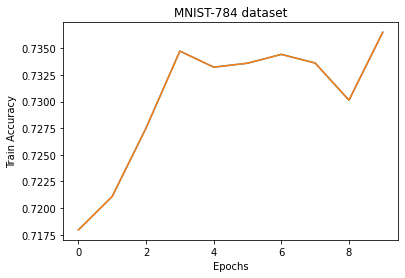

In [20]:
from matplotlib import pyplot as plt
plt.xlabel('Epochs')
plt.ylabel('Train Accuracy')
plt.title('MNIST-784 dataset')
plt.plot(acc)
plt.plot(acc)

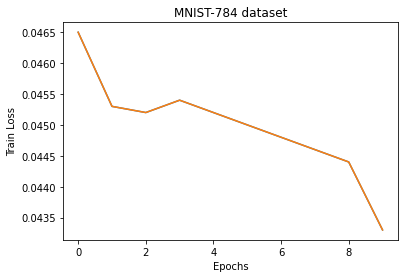

In [22]:
plt.xlabel('Epochs')
plt.ylabel('Train Loss')
plt.title('MNIST-784 dataset')
plt.plot(loss)
plt.plot(loss)

# Case 7

Hyper Parameter Optimization for Batch Size using Trial and Error


## Batch Size = 20 (default)

In [ ]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden, self.size_output, self.device =\
    size_input, size_hidden, size_output, device
    
    # Initialize weights between input layer and hidden layer-1
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden[0]]))
    # Initialize biases for hidden layer-1
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden[0]]))

    # Initialize weights between hidden layer-1 and hidden layer-2
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden[0], self.size_hidden[1]]))
    # Initialize biases for hidden layer-1
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden[1]]))

     # Initialize weights between hidden layer and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden[1], self.size_output]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
    
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.keras.losses.CategoricalCrossentropy()(y_true_tf, y_pred_tf)
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
        
        
  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer1
    what1 = tf.matmul(X_tf, self.W1) + self.b1
    hhat1 = tf.nn.relu(what1)
    # Compute values in hidden layer2
    what2 = tf.matmul(hhat1, self.W2) + self.b2
    hhat2 = tf.nn.relu(what2)
    # Compute output
    output = tf.matmul(hhat2, self.W3) + self.b3
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

In [ ]:
#Default mode
mlp_on_default = MLP(size_input, size_hidden, size_output)

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  accuracy_a = tf.zeros([], dtype=tf.float32) #tensor for accumulating accuracy
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=epoch*(5997)).batch(20)
  for inputs, outputs in train_ds:
    preds = mlp_on_default.forward(inputs)
    pred = tf.nn.softmax(preds)


    outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
    pred = tf.cast(pred, dtype=tf.float32)

    correct_prediction = tf.equal(tf.argmax(outputs, 1), tf.argmax(pred, 1))
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))



    accuracy_a = accuracy_a + accuracy
    loss_total_gpu = loss_total_gpu + mlp_on_default.loss(preds, outputs)
    lt = lt + mlp_on_default.loss(preds, outputs)
    mlp_on_default.backward(inputs, outputs)
  print('Number of Epoch = {} - Categorical Cross-Entropy:= {}'.format(epoch + 1, np.sum(loss_total_gpu) / x_train.shape[0]))
  print('Number of Epoch = {} - Accuracy:= {}'.format(epoch + 1, (np.sum(accuracy_a) / x_train.shape[0])*100))
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

Number of Epoch = 1 - Categorical Cross-Entropy:= 0.30573391544117645
Number of Epoch = 1 - Accuracy:= 0.4708428390887605
Number of Epoch = 2 - Categorical Cross-Entropy:= 0.25576692161239495
Number of Epoch = 2 - Accuracy:= 0.5183211126247373
Number of Epoch = 3 - Categorical Cross-Entropy:= 0.2125008862920168
Number of Epoch = 3 - Accuracy:= 0.5553782743566177
Number of Epoch = 4 - Categorical Cross-Entropy:= 0.18682595850840336
Number of Epoch = 4 - Accuracy:= 0.5611766654904149
Number of Epoch = 5 - Categorical Cross-Entropy:= 0.17022198332457983
Number of Epoch = 5 - Accuracy:= 0.570252234194459
Number of Epoch = 6 - Categorical Cross-Entropy:= 0.15364607405462186
Number of Epoch = 6 - Accuracy:= 0.5889914632845326
Number of Epoch = 7 - Categorical Cross-Entropy:= 0.1418840762867647
Number of Epoch = 7 - Accuracy:= 0.6093281721868434
Number of Epoch = 8 - Categorical Cross-Entropy:= 0.1343160287552521
Number of Epoch = 8 - Accuracy:= 0.6256299443605567
Number of Epoch = 9 - Catego

In [ ]:
test_loss_total = tf.Variable(0, dtype=tf.float32)
accuracy_a = tf.zeros([], dtype=tf.float32)
#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlp_on_default.forward(inputs)

  pred = tf.nn.softmax(preds)  # Apply softmax to logits
  outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
  pred = tf.cast(pred, dtype=tf.float32)

  correct_prediction = tf.equal(tf.argmax(outputs, 1), tf.argmax(pred, 1))
  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  accuracy_a = accuracy_a + accuracy
  #b = mlp_on_default.loss(preds, outputs)
  test_loss_total = test_loss_total + mlp_on_default.loss(preds, outputs)
# a = (test_loss_total.numpy() / X_train.shape[0])
# print(X_train.shape[0])
# print(test_loss_total.numpy())
# print(b)
print('Test Categorical_Cross-Entropy: {:.4f}'.format(np.sum(test_loss_total.numpy()) / x_train.shape[0]))
print('Test Accuracy: {:.4f}'.format((np.sum(accuracy_a) / x_train.shape[0])*100))

Test Categorical_Cross-Entropy: 0.1070
Test Accuracy: 0.5895


## Batch Size = 256

In [ ]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden, self.size_output, self.device =\
    size_input, size_hidden, size_output, device
    
    # Initialize weights between input layer and hidden layer-1
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden[0]]))
    # Initialize biases for hidden layer-1
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden[0]]))

    # Initialize weights between hidden layer-1 and hidden layer-2
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden[0], self.size_hidden[1]]))
    # Initialize biases for hidden layer-1
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden[1]]))

     # Initialize weights between hidden layer and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden[1], self.size_output]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
    
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.keras.losses.CategoricalCrossentropy()(y_true_tf, y_pred_tf)
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
        
        
  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer1
    what1 = tf.matmul(X_tf, self.W1) + self.b1
    hhat1 = tf.nn.relu(what1)
    # Compute values in hidden layer2
    what2 = tf.matmul(hhat1, self.W2) + self.b2
    hhat2 = tf.nn.relu(what2)
    # Compute output
    output = tf.matmul(hhat2, self.W3) + self.b3
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

In [ ]:
#Default mode
mlp_on_default = MLP(size_input, size_hidden, size_output)

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  accuracy_a = tf.zeros([], dtype=tf.float32) #tensor for accumulating accuracy
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=epoch*(5997)).batch(256)
  for inputs, outputs in train_ds:
    preds = mlp_on_default.forward(inputs)
    pred = tf.nn.softmax(preds)


    outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
    pred = tf.cast(pred, dtype=tf.float32)

    correct_prediction = tf.equal(tf.argmax(outputs, 1), tf.argmax(pred, 1))
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))



    accuracy_a = accuracy_a + accuracy
    loss_total_gpu = loss_total_gpu + mlp_on_default.loss(preds, outputs)
    lt = lt + mlp_on_default.loss(preds, outputs)
    mlp_on_default.backward(inputs, outputs)
  print('Number of Epoch = {} - Categorical Cross-Entropy:= {}'.format(epoch + 1, np.sum(loss_total_gpu) / x_train.shape[0]))
  print('Number of Epoch = {} - Accuracy:= {}'.format(epoch + 1, (np.sum(accuracy_a) / x_train.shape[0])*100))
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

Number of Epoch = 1 - Categorical Cross-Entropy:= 0.029556712431066178
Number of Epoch = 1 - Accuracy:= 0.04359851484539128
Number of Epoch = 2 - Categorical Cross-Entropy:= 0.029474002100840335
Number of Epoch = 2 - Accuracy:= 0.043638636484867384
Number of Epoch = 3 - Categorical Cross-Entropy:= 0.029408348788734245
Number of Epoch = 3 - Accuracy:= 0.04367972942961364
Number of Epoch = 4 - Categorical Cross-Entropy:= 0.02934698127297794
Number of Epoch = 4 - Accuracy:= 0.043690426610097165
Number of Epoch = 5 - Categorical Cross-Entropy:= 0.02930344012605042
Number of Epoch = 5 - Accuracy:= 0.043712555059865744
Number of Epoch = 6 - Categorical Cross-Entropy:= 0.029254142184217437
Number of Epoch = 6 - Accuracy:= 0.043701854673754266
Number of Epoch = 7 - Categorical Cross-Entropy:= 0.02919454725249475
Number of Epoch = 7 - Accuracy:= 0.043716687114298845
Number of Epoch = 8 - Categorical Cross-Entropy:= 0.029116766921612396
Number of Epoch = 8 - Accuracy:= 0.043716687114298845
Numbe

In [ ]:
test_loss_total = tf.Variable(0, dtype=tf.float32)
accuracy_a = tf.zeros([], dtype=tf.float32)
#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlp_on_default.forward(inputs)

  pred = tf.nn.softmax(preds)  # Apply softmax to logits
  outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
  pred = tf.cast(pred, dtype=tf.float32)

  correct_prediction = tf.equal(tf.argmax(outputs, 1), tf.argmax(pred, 1))
  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  accuracy_a = accuracy_a + accuracy
  #b = mlp_on_default.loss(preds, outputs)
  test_loss_total = test_loss_total + mlp_on_default.loss(preds, outputs)
# a = (test_loss_total.numpy() / X_train.shape[0])
# print(X_train.shape[0])
# print(test_loss_total.numpy())
# print(b)
print('Test Categorical_Cross-Entropy: {:.4f}'.format(np.sum(test_loss_total.numpy()) / x_train.shape[0]))
print('Test Accuracy: {:.4f}'.format((np.sum(accuracy_a) / x_train.shape[0])*100))

Test Categorical_Cross-Entropy: 0.3290
Test Accuracy: 0.5038


# Case 8

Hyper Parameter Optimization for Optimizers - AdaM instead of SGD using Trial and Error

## SGD

In [ ]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden, self.size_output, self.device =\
    size_input, size_hidden, size_output, device
    
    # Initialize weights between input layer and hidden layer-1
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden[0]]))
    # Initialize biases for hidden layer-1
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden[0]]))

    # Initialize weights between hidden layer-1 and hidden layer-2
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden[0], self.size_hidden[1]]))
    # Initialize biases for hidden layer-1
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden[1]]))

     # Initialize weights between hidden layer and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden[1], self.size_output]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
    
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.keras.losses.CategoricalCrossentropy()(y_true_tf, y_pred_tf)
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
        
        
  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer1
    what1 = tf.matmul(X_tf, self.W1) + self.b1
    hhat1 = tf.nn.relu(what1)
    # Compute values in hidden layer2
    what2 = tf.matmul(hhat1, self.W2) + self.b2
    hhat2 = tf.nn.relu(what2)
    # Compute output
    output = tf.matmul(hhat2, self.W3) + self.b3
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

In [ ]:
#Default mode
mlp_on_default = MLP(size_input, size_hidden, size_output)

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  accuracy_a = tf.zeros([], dtype=tf.float32) #tensor for accumulating accuracy
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=epoch*(5997)).batch(20)
  for inputs, outputs in train_ds:
    preds = mlp_on_default.forward(inputs)
    pred = tf.nn.softmax(preds)


    outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
    pred = tf.cast(pred, dtype=tf.float32)

    correct_prediction = tf.equal(tf.argmax(outputs, 1), tf.argmax(pred, 1))
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))



    accuracy_a = accuracy_a + accuracy
    loss_total_gpu = loss_total_gpu + mlp_on_default.loss(preds, outputs)
    lt = lt + mlp_on_default.loss(preds, outputs)
    mlp_on_default.backward(inputs, outputs)
  print('Number of Epoch = {} - Categorical Cross-Entropy:= {}'.format(epoch + 1, np.sum(loss_total_gpu) / x_train.shape[0]))
  print('Number of Epoch = {} - Accuracy:= {}'.format(epoch + 1, (np.sum(accuracy_a) / x_train.shape[0])*100))
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

Number of Epoch = 1 - Categorical Cross-Entropy:= 0.30573391544117645
Number of Epoch = 1 - Accuracy:= 0.4708428390887605
Number of Epoch = 2 - Categorical Cross-Entropy:= 0.25576692161239495
Number of Epoch = 2 - Accuracy:= 0.5183211126247373
Number of Epoch = 3 - Categorical Cross-Entropy:= 0.2125008862920168
Number of Epoch = 3 - Accuracy:= 0.5553782743566177
Number of Epoch = 4 - Categorical Cross-Entropy:= 0.18682595850840336
Number of Epoch = 4 - Accuracy:= 0.5611766654904149
Number of Epoch = 5 - Categorical Cross-Entropy:= 0.17022198332457983
Number of Epoch = 5 - Accuracy:= 0.570252234194459
Number of Epoch = 6 - Categorical Cross-Entropy:= 0.15364607405462186
Number of Epoch = 6 - Accuracy:= 0.5889914632845326
Number of Epoch = 7 - Categorical Cross-Entropy:= 0.1418840762867647
Number of Epoch = 7 - Accuracy:= 0.6093281721868434
Number of Epoch = 8 - Categorical Cross-Entropy:= 0.1343160287552521
Number of Epoch = 8 - Accuracy:= 0.6256299443605567
Number of Epoch = 9 - Catego

In [ ]:
test_loss_total = tf.Variable(0, dtype=tf.float32)
accuracy_a = tf.zeros([], dtype=tf.float32)
#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlp_on_default.forward(inputs)

  pred = tf.nn.softmax(preds)  # Apply softmax to logits
  outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
  pred = tf.cast(pred, dtype=tf.float32)

  correct_prediction = tf.equal(tf.argmax(outputs, 1), tf.argmax(pred, 1))
  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  accuracy_a = accuracy_a + accuracy
  #b = mlp_on_default.loss(preds, outputs)
  test_loss_total = test_loss_total + mlp_on_default.loss(preds, outputs)
# a = (test_loss_total.numpy() / X_train.shape[0])
# print(X_train.shape[0])
# print(test_loss_total.numpy())
# print(b)
print('Test Categorical_Cross-Entropy: {:.4f}'.format(np.sum(test_loss_total.numpy()) / x_train.shape[0]))
print('Test Accuracy: {:.4f}'.format((np.sum(accuracy_a) / x_train.shape[0])*100))

Test Categorical_Cross-Entropy: 0.1070
Test Accuracy: 0.5895


## Adam

In [ ]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden, self.size_output, self.device =\
    size_input, size_hidden, size_output, device
    
    # Initialize weights between input layer and hidden layer-1
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden[0]]))
    # Initialize biases for hidden layer-1
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden[0]]))

    # Initialize weights between hidden layer-1 and hidden layer-2
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden[0], self.size_hidden[1]]))
    # Initialize biases for hidden layer-1
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden[1]]))

     # Initialize weights between hidden layer and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden[1], self.size_output]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
    
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.keras.losses.CategoricalCrossentropy()(y_true_tf, y_pred_tf)
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
        
        
  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer1
    what1 = tf.matmul(X_tf, self.W1) + self.b1
    hhat1 = tf.nn.relu(what1)
    # Compute values in hidden layer2
    what2 = tf.matmul(hhat1, self.W2) + self.b2
    hhat2 = tf.nn.relu(what2)
    # Compute output
    output = tf.matmul(hhat2, self.W3) + self.b3
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

In [ ]:
#Default mode
mlp_on_default = MLP(size_input, size_hidden, size_output)

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  accuracy_a = tf.zeros([], dtype=tf.float32) #tensor for accumulating accuracy
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=epoch*(5997)).batch(20)
  for inputs, outputs in train_ds:
    preds = mlp_on_default.forward(inputs)
    pred = preds


    outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
    pred = tf.cast(pred, dtype=tf.float32)

    correct_prediction = tf.equal(tf.argmax(outputs, 1), tf.argmax(pred, 1))
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))



    accuracy_a = accuracy_a + accuracy
    loss_total_gpu = loss_total_gpu + mlp_on_default.loss(preds, outputs)
    lt = lt + mlp_on_default.loss(preds, outputs)
    mlp_on_default.backward(inputs, outputs)
  print('Number of Epoch = {} - Categorical Cross-Entropy:= {}'.format(epoch + 1, np.sum(loss_total_gpu) / x_train.shape[0]))
  print('Number of Epoch = {} - Accuracy:= {}'.format(epoch + 1, (np.sum(accuracy_a) / x_train.shape[0])*100))
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

Number of Epoch = 1 - Categorical Cross-Entropy:= 0.028099601168592437
Number of Epoch = 1 - Accuracy:= 0.6108154168649882
Number of Epoch = 2 - Categorical Cross-Entropy:= 0.031094342912946427
Number of Epoch = 2 - Accuracy:= 0.6780083279649751
Number of Epoch = 3 - Categorical Cross-Entropy:= 0.030274124786633404
Number of Epoch = 3 - Accuracy:= 0.6624133326426274
Number of Epoch = 4 - Categorical Cross-Entropy:= 0.02807934980632878
Number of Epoch = 4 - Accuracy:= 0.6390323799197414
Number of Epoch = 5 - Categorical Cross-Entropy:= 0.026592871914390755
Number of Epoch = 5 - Accuracy:= 0.6783629986418396
Number of Epoch = 6 - Categorical Cross-Entropy:= 0.02693370658810399
Number of Epoch = 6 - Accuracy:= 0.7723327123818278
Number of Epoch = 7 - Categorical Cross-Entropy:= 0.02939727834493172
Number of Epoch = 7 - Accuracy:= 0.8076380240817029
Number of Epoch = 8 - Categorical Cross-Entropy:= 0.030392910484506302
Number of Epoch = 8 - Accuracy:= 0.8262172666918329
Number of Epoch = 9

In [ ]:
test_loss_total = tf.Variable(0, dtype=tf.float32)
accuracy_a = tf.zeros([], dtype=tf.float32)
#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlp_on_default.forward(inputs)

  pred = tf.nn.softmax(preds)  # Apply softmax to logits
  outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
  pred = tf.cast(pred, dtype=tf.float32)

  correct_prediction = tf.equal(tf.argmax(outputs, 1), tf.argmax(pred, 1))
  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  accuracy_a = accuracy_a + accuracy
  #b = mlp_on_default.loss(preds, outputs)
  test_loss_total = test_loss_total + mlp_on_default.loss(preds, outputs)
# a = (test_loss_total.numpy() / X_train.shape[0])
# print(X_train.shape[0])
# print(test_loss_total.numpy())
# print(b)
print('Test Categorical_Cross-Entropy: {:.4f}'.format(np.sum(test_loss_total.numpy()) / x_train.shape[0]))
print('Test Accuracy: {:.4f}'.format((np.sum(accuracy_a) / x_train.shape[0])*100))

# Case 9

Hyper Parameter Optimization for Learning Rate using Trial and Error

## 1e-4



In [ ]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden, self.size_output, self.device =\
    size_input, size_hidden, size_output, device
    
    # Initialize weights between input layer and hidden layer-1
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden[0]]))
    # Initialize biases for hidden layer-1
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden[0]]))

    # Initialize weights between hidden layer-1 and hidden layer-2
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden[0], self.size_hidden[1]]))
    # Initialize biases for hidden layer-1
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden[1]]))

     # Initialize weights between hidden layer and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden[1], self.size_output]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
    
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.keras.losses.CategoricalCrossentropy()(y_true_tf, y_pred_tf)
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
        
        
  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer1
    what1 = tf.matmul(X_tf, self.W1) + self.b1
    hhat1 = tf.nn.relu(what1)
    # Compute values in hidden layer2
    what2 = tf.matmul(hhat1, self.W2) + self.b2
    hhat2 = tf.nn.relu(what2)
    # Compute output
    output = tf.matmul(hhat2, self.W3) + self.b3
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

In [ ]:
#Default mode
mlp_on_default = MLP(size_input, size_hidden, size_output)

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  accuracy_a = tf.zeros([], dtype=tf.float32) #tensor for accumulating accuracy
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=epoch*(5997)).batch(20)
  for inputs, outputs in train_ds:
    preds = mlp_on_default.forward(inputs)
    pred = tf.nn.softmax(preds)


    outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
    pred = tf.cast(pred, dtype=tf.float32)

    correct_prediction = tf.equal(tf.argmax(outputs, 1), tf.argmax(pred, 1))
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))



    accuracy_a = accuracy_a + accuracy
    loss_total_gpu = loss_total_gpu + mlp_on_default.loss(preds, outputs)
    lt = lt + mlp_on_default.loss(preds, outputs)
    mlp_on_default.backward(inputs, outputs)
  print('Number of Epoch = {} - Categorical Cross-Entropy:= {}'.format(epoch + 1, np.sum(loss_total_gpu) / x_train.shape[0]))
  print('Number of Epoch = {} - Accuracy:= {}'.format(epoch + 1, (np.sum(accuracy_a) / x_train.shape[0])*100))
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

Number of Epoch = 1 - Categorical Cross-Entropy:= 0.30573391544117645
Number of Epoch = 1 - Accuracy:= 0.4708428390887605
Number of Epoch = 2 - Categorical Cross-Entropy:= 0.25576692161239495
Number of Epoch = 2 - Accuracy:= 0.5183211126247373
Number of Epoch = 3 - Categorical Cross-Entropy:= 0.2125008862920168
Number of Epoch = 3 - Accuracy:= 0.5553782743566177
Number of Epoch = 4 - Categorical Cross-Entropy:= 0.18682595850840336
Number of Epoch = 4 - Accuracy:= 0.5611766654904149
Number of Epoch = 5 - Categorical Cross-Entropy:= 0.17022198332457983
Number of Epoch = 5 - Accuracy:= 0.570252234194459
Number of Epoch = 6 - Categorical Cross-Entropy:= 0.15364607405462186
Number of Epoch = 6 - Accuracy:= 0.5889914632845326
Number of Epoch = 7 - Categorical Cross-Entropy:= 0.1418840762867647
Number of Epoch = 7 - Accuracy:= 0.6093281721868434
Number of Epoch = 8 - Categorical Cross-Entropy:= 0.1343160287552521
Number of Epoch = 8 - Accuracy:= 0.6256299443605567
Number of Epoch = 9 - Catego

In [ ]:
test_loss_total = tf.Variable(0, dtype=tf.float32)
accuracy_a = tf.zeros([], dtype=tf.float32)
#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlp_on_default.forward(inputs)

  pred = tf.nn.softmax(preds)  # Apply softmax to logits
  outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
  pred = tf.cast(pred, dtype=tf.float32)

  correct_prediction = tf.equal(tf.argmax(outputs, 1), tf.argmax(pred, 1))
  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  accuracy_a = accuracy_a + accuracy
  #b = mlp_on_default.loss(preds, outputs)
  test_loss_total = test_loss_total + mlp_on_default.loss(preds, outputs)
# a = (test_loss_total.numpy() / X_train.shape[0])
# print(X_train.shape[0])
# print(test_loss_total.numpy())
# print(b)
print('Test Categorical_Cross-Entropy: {:.4f}'.format(np.sum(test_loss_total.numpy()) / x_train.shape[0]))
print('Test Accuracy: {:.4f}'.format((np.sum(accuracy_a) / x_train.shape[0])*100))

Test Categorical_Cross-Entropy: 0.1070
Test Accuracy: 0.5895


## 1e-3

In [ ]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden, self.size_output, self.device =\
    size_input, size_hidden, size_output, device
    
    # Initialize weights between input layer and hidden layer-1
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden[0]]))
    # Initialize biases for hidden layer-1
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden[0]]))

    # Initialize weights between hidden layer-1 and hidden layer-2
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden[0], self.size_hidden[1]]))
    # Initialize biases for hidden layer-1
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden[1]]))

     # Initialize weights between hidden layer and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden[1], self.size_output]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
    
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.keras.losses.CategoricalCrossentropy()(y_true_tf, y_pred_tf)
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
        
        
  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer1
    what1 = tf.matmul(X_tf, self.W1) + self.b1
    hhat1 = tf.nn.relu(what1)
    # Compute values in hidden layer2
    what2 = tf.matmul(hhat1, self.W2) + self.b2
    hhat2 = tf.nn.relu(what2)
    # Compute output
    output = tf.matmul(hhat2, self.W3) + self.b3
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

In [ ]:
#Default mode
mlp_on_default = MLP(size_input, size_hidden, size_output)

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  accuracy_a = tf.zeros([], dtype=tf.float32) #tensor for accumulating accuracy
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=epoch*(5997)).batch(20)
  for inputs, outputs in train_ds:
    preds = mlp_on_default.forward(inputs)
    pred = tf.nn.softmax(preds)


    outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
    pred = tf.cast(pred, dtype=tf.float32)

    correct_prediction = tf.equal(tf.argmax(outputs, 1), tf.argmax(pred, 1))
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))



    accuracy_a = accuracy_a + accuracy
    loss_total_gpu = loss_total_gpu + mlp_on_default.loss(preds, outputs)
    lt = lt + mlp_on_default.loss(preds, outputs)
    mlp_on_default.backward(inputs, outputs)
  print('Number of Epoch = {} - Categorical Cross-Entropy:= {}'.format(epoch + 1, np.sum(loss_total_gpu) / x_train.shape[0]))
  print('Number of Epoch = {} - Accuracy:= {}'.format(epoch + 1, (np.sum(accuracy_a) / x_train.shape[0])*100))
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

Number of Epoch = 1 - Categorical Cross-Entropy:= 0.3356025800945378
Number of Epoch = 1 - Accuracy:= 0.5032789727219013
Number of Epoch = 2 - Categorical Cross-Entropy:= 0.22050091911764705
Number of Epoch = 2 - Accuracy:= 0.5159667455849527
Number of Epoch = 3 - Categorical Cross-Entropy:= 0.2503140263918067
Number of Epoch = 3 - Accuracy:= 0.5105902663799895
Number of Epoch = 4 - Categorical Cross-Entropy:= 0.35725544905462187
Number of Epoch = 4 - Accuracy:= 0.4324413139279149
Number of Epoch = 5 - Categorical Cross-Entropy:= 0.24452031906512606
Number of Epoch = 5 - Accuracy:= 0.3936176716780462
Number of Epoch = 6 - Categorical Cross-Entropy:= 0.23529111410189077
Number of Epoch = 6 - Accuracy:= 0.41151674414883144
Number of Epoch = 7 - Categorical Cross-Entropy:= 0.22938906578256302
Number of Epoch = 7 - Accuracy:= 0.44395295471704305
Number of Epoch = 8 - Categorical Cross-Entropy:= 0.2231200105042017
Number of Epoch = 8 - Accuracy:= 0.4885735519793855
Number of Epoch = 9 - Cat

In [ ]:
test_loss_total = tf.Variable(0, dtype=tf.float32)
accuracy_a = tf.zeros([], dtype=tf.float32)
#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlp_on_default.forward(inputs)

  pred = tf.nn.softmax(preds)  # Apply softmax to logits
  outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
  pred = tf.cast(pred, dtype=tf.float32)

  correct_prediction = tf.equal(tf.argmax(outputs, 1), tf.argmax(pred, 1))
  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  accuracy_a = accuracy_a + accuracy
  #b = mlp_on_default.loss(preds, outputs)
  test_loss_total = test_loss_total + mlp_on_default.loss(preds, outputs)
# a = (test_loss_total.numpy() / X_train.shape[0])
# print(X_train.shape[0])
# print(test_loss_total.numpy())
# print(b)
print('Test Categorical_Cross-Entropy: {:.4f}'.format(np.sum(test_loss_total.numpy()) / x_train.shape[0]))
print('Test Accuracy: {:.4f}'.format((np.sum(accuracy_a) / x_train.shape[0])*100))

Test Categorical_Cross-Entropy: 0.3661
Test Accuracy: 0.4277


## ie-5

In [ ]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden, self.size_output, self.device =\
    size_input, size_hidden, size_output, device
    
    # Initialize weights between input layer and hidden layer-1
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden[0]]))
    # Initialize biases for hidden layer-1
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden[0]]))

    # Initialize weights between hidden layer-1 and hidden layer-2
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden[0], self.size_hidden[1]]))
    # Initialize biases for hidden layer-1
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden[1]]))

     # Initialize weights between hidden layer and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden[1], self.size_output]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
    
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.keras.losses.CategoricalCrossentropy()(y_true_tf, y_pred_tf)
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
        
        
  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer1
    what1 = tf.matmul(X_tf, self.W1) + self.b1
    hhat1 = tf.nn.relu(what1)
    # Compute values in hidden layer2
    what2 = tf.matmul(hhat1, self.W2) + self.b2
    hhat2 = tf.nn.relu(what2)
    # Compute output
    output = tf.matmul(hhat2, self.W3) + self.b3
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

In [ ]:
#Default mode
mlp_on_default = MLP(size_input, size_hidden, size_output)

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  accuracy_a = tf.zeros([], dtype=tf.float32) #tensor for accumulating accuracy
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=epoch*(5997)).batch(20)
  for inputs, outputs in train_ds:
    preds = mlp_on_default.forward(inputs)
    pred = tf.nn.softmax(preds)


    outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
    pred = tf.cast(pred, dtype=tf.float32)

    correct_prediction = tf.equal(tf.argmax(outputs, 1), tf.argmax(pred, 1))
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))



    accuracy_a = accuracy_a + accuracy
    loss_total_gpu = loss_total_gpu + mlp_on_default.loss(preds, outputs)
    lt = lt + mlp_on_default.loss(preds, outputs)
    mlp_on_default.backward(inputs, outputs)
  print('Number of Epoch = {} - Categorical Cross-Entropy:= {}'.format(epoch + 1, np.sum(loss_total_gpu) / x_train.shape[0]))
  print('Number of Epoch = {} - Accuracy:= {}'.format(epoch + 1, (np.sum(accuracy_a) / x_train.shape[0])*100))
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

Number of Epoch = 1 - Categorical Cross-Entropy:= 0.32479851628151263
Number of Epoch = 1 - Accuracy:= 0.4610115115382091
Number of Epoch = 2 - Categorical Cross-Entropy:= 0.31970000656512604
Number of Epoch = 2 - Accuracy:= 0.4584896824940914
Number of Epoch = 3 - Categorical Cross-Entropy:= 0.3176233915441177
Number of Epoch = 3 - Accuracy:= 0.4598348152737658
Number of Epoch = 4 - Categorical Cross-Entropy:= 0.31290296743697477
Number of Epoch = 4 - Accuracy:= 0.4638682133009454
Number of Epoch = 5 - Categorical Cross-Entropy:= 0.3082079175420168
Number of Epoch = 5 - Accuracy:= 0.4627750172334559
Number of Epoch = 6 - Categorical Cross-Entropy:= 0.30051037289915966
Number of Epoch = 6 - Accuracy:= 0.46622058002888656
Number of Epoch = 7 - Categorical Cross-Entropy:= 0.29514206932773107
Number of Epoch = 7 - Accuracy:= 0.4667256844143907
Number of Epoch = 8 - Categorical Cross-Entropy:= 0.2908782825630252
Number of Epoch = 8 - Accuracy:= 0.4928585276884191
Number of Epoch = 9 - Cate

In [ ]:
test_loss_total = tf.Variable(0, dtype=tf.float32)
accuracy_a = tf.zeros([], dtype=tf.float32)
#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlp_on_default.forward(inputs)

  pred = tf.nn.softmax(preds)  # Apply softmax to logits
  outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
  pred = tf.cast(pred, dtype=tf.float32)

  correct_prediction = tf.equal(tf.argmax(outputs, 1), tf.argmax(pred, 1))
  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  accuracy_a = accuracy_a + accuracy
  #b = mlp_on_default.loss(preds, outputs)
  test_loss_total = test_loss_total + mlp_on_default.loss(preds, outputs)
# a = (test_loss_total.numpy() / X_train.shape[0])
# print(X_train.shape[0])
# print(test_loss_total.numpy())
# print(b)
print('Test Categorical_Cross-Entropy: {:.4f}'.format(np.sum(test_loss_total.numpy()) / x_train.shape[0]))
print('Test Accuracy: {:.4f}'.format((np.sum(accuracy_a) / x_train.shape[0])*100))

Test Categorical_Cross-Entropy: 0.2415
Test Accuracy: 0.4479


# Case 10

Hyper Parameter Optimization for Activation Function using Trial and Error

## Relu

In [ ]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden, self.size_output, self.device =\
    size_input, size_hidden, size_output, device
    
    # Initialize weights between input layer and hidden layer-1
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden[0]]))
    # Initialize biases for hidden layer-1
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden[0]]))

    # Initialize weights between hidden layer-1 and hidden layer-2
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden[0], self.size_hidden[1]]))
    # Initialize biases for hidden layer-1
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden[1]]))

     # Initialize weights between hidden layer and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden[1], self.size_output]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
    
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.keras.losses.CategoricalCrossentropy()(y_true_tf, y_pred_tf)
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
        
        
  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer1
    what1 = tf.matmul(X_tf, self.W1) + self.b1
    hhat1 = tf.nn.relu(what1)
    # Compute values in hidden layer2
    what2 = tf.matmul(hhat1, self.W2) + self.b2
    hhat2 = tf.nn.relu(what2)
    # Compute output
    output = tf.matmul(hhat2, self.W3) + self.b3
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

In [ ]:
# Set number of epochs
NUM_EPOCHS = 10

In [ ]:
#Default mode
mlp_on_default = MLP(size_input, size_hidden, size_output)

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  accuracy_a = tf.zeros([], dtype=tf.float32) #tensor for accumulating accuracy
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=epoch*(5997)).batch(20)
  for inputs, outputs in train_ds:
    preds = mlp_on_default.forward(inputs)
    pred = tf.nn.softmax(preds)


    outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
    pred = tf.cast(pred, dtype=tf.float32)

    correct_prediction = tf.equal(tf.argmax(outputs, 1), tf.argmax(pred, 1))
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))



    accuracy_a = accuracy_a + accuracy
    loss_total_gpu = loss_total_gpu + mlp_on_default.loss(preds, outputs)
    lt = lt + mlp_on_default.loss(preds, outputs)
    mlp_on_default.backward(inputs, outputs)
  print('Number of Epoch = {} - Categorical Cross-Entropy:= {}'.format(epoch + 1, np.sum(loss_total_gpu) / x_train.shape[0]))
  print('Number of Epoch = {} - Accuracy:= {}'.format(epoch + 1, (np.sum(accuracy_a) / x_train.shape[0])*100))
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

Number of Epoch = 1 - Categorical Cross-Entropy:= 0.30573391544117645
Number of Epoch = 1 - Accuracy:= 0.4708428390887605
Number of Epoch = 2 - Categorical Cross-Entropy:= 0.25576692161239495
Number of Epoch = 2 - Accuracy:= 0.5183211126247373
Number of Epoch = 3 - Categorical Cross-Entropy:= 0.2125008862920168
Number of Epoch = 3 - Accuracy:= 0.5553782743566177
Number of Epoch = 4 - Categorical Cross-Entropy:= 0.18682595850840336
Number of Epoch = 4 - Accuracy:= 0.5611766654904149
Number of Epoch = 5 - Categorical Cross-Entropy:= 0.17022198332457983
Number of Epoch = 5 - Accuracy:= 0.570252234194459
Number of Epoch = 6 - Categorical Cross-Entropy:= 0.15364607405462186
Number of Epoch = 6 - Accuracy:= 0.5889914632845326
Number of Epoch = 7 - Categorical Cross-Entropy:= 0.1418840762867647
Number of Epoch = 7 - Accuracy:= 0.6093281721868434
Number of Epoch = 8 - Categorical Cross-Entropy:= 0.1343160287552521
Number of Epoch = 8 - Accuracy:= 0.6256299443605567
Number of Epoch = 9 - Catego

In [ ]:
test_loss_total = tf.Variable(0, dtype=tf.float32)
accuracy_a = tf.zeros([], dtype=tf.float32)
#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlp_on_default.forward(inputs)

  pred = tf.nn.softmax(preds)  # Apply softmax to logits
  outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
  pred = tf.cast(pred, dtype=tf.float32)

  correct_prediction = tf.equal(tf.argmax(outputs, 1), tf.argmax(pred, 1))
  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  accuracy_a = accuracy_a + accuracy
  #b = mlp_on_default.loss(preds, outputs)
  test_loss_total = test_loss_total + mlp_on_default.loss(preds, outputs)
# a = (test_loss_total.numpy() / X_train.shape[0])
# print(X_train.shape[0])
# print(test_loss_total.numpy())
# print(b)
print('Test Categorical_Cross-Entropy: {:.4f}'.format(np.sum(test_loss_total.numpy()) / x_train.shape[0]))
print('Test Accuracy: {:.4f}'.format((np.sum(accuracy_a) / x_train.shape[0])*100))

Test Categorical_Cross-Entropy: 0.1070
Test Accuracy: 0.5895


## Tanh

In [ ]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden, self.size_output, self.device =\
    size_input, size_hidden, size_output, device
    
    # Initialize weights between input layer and hidden layer-1
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden[0]]))
    # Initialize biases for hidden layer-1
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden[0]]))

    # Initialize weights between hidden layer-1 and hidden layer-2
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden[0], self.size_hidden[1]]))
    # Initialize biases for hidden layer-1
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden[1]]))

     # Initialize weights between hidden layer and output layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden[1], self.size_output]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
    
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.keras.losses.CategoricalCrossentropy()(y_true_tf, y_pred_tf)
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
        
        
  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in hidden layer1
    what1 = tf.matmul(X_tf, self.W1) + self.b1
    hhat1 = tf.nn.tanh(what1)
    # Compute values in hidden layer2
    what2 = tf.matmul(hhat1, self.W2) + self.b2
    hhat2 = tf.nn.tanh(what2)
    # Compute output
    output = tf.matmul(hhat2, self.W3) + self.b3
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

In [ ]:
# Set number of epochs
NUM_EPOCHS = 10

In [ ]:
#Default mode
mlp_on_default = MLP(size_input, size_hidden, size_output)

time_start = time.time()
for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  accuracy_a = tf.zeros([], dtype=tf.float32) #tensor for accumulating accuracy
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=epoch*(5997)).batch(20)
  for inputs, outputs in train_ds:
    preds = mlp_on_default.forward(inputs)
    pred = preds


    outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
    pred = tf.cast(pred, dtype=tf.float32)

    correct_prediction = tf.equal(tf.argmax(outputs, 1), tf.argmax(pred, 1))
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))



    accuracy_a = accuracy_a + accuracy
    loss_total_gpu = loss_total_gpu + mlp_on_default.loss(preds, outputs)
    lt = lt + mlp_on_default.loss(preds, outputs)
    mlp_on_default.backward(inputs, outputs)
  print('Number of Epoch = {} - Categorical Cross-Entropy:= {}'.format(epoch + 1, np.sum(loss_total_gpu) / x_train.shape[0]))
  print('Number of Epoch = {} - Accuracy:= {}'.format(epoch + 1, (np.sum(accuracy_a) / x_train.shape[0])*100))
time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))

Number of Epoch = 1 - Categorical Cross-Entropy:= 0.026894543559611343
Number of Epoch = 1 - Accuracy:= 0.45227396989069063
Number of Epoch = 2 - Categorical Cross-Entropy:= 0.026803446280856093
Number of Epoch = 2 - Accuracy:= 0.45194571358816965
Number of Epoch = 3 - Categorical Cross-Entropy:= 0.026746319426207983
Number of Epoch = 3 - Accuracy:= 0.4529061517795595
Number of Epoch = 4 - Categorical Cross-Entropy:= 0.026674517463235296
Number of Epoch = 4 - Accuracy:= 0.45352862061572674
Number of Epoch = 5 - Categorical Cross-Entropy:= 0.026487942735688025
Number of Epoch = 5 - Accuracy:= 0.46576652206292674
Number of Epoch = 6 - Categorical Cross-Entropy:= 0.025454971441701682
Number of Epoch = 6 - Accuracy:= 0.5390406376173517
Number of Epoch = 7 - Categorical Cross-Entropy:= 0.025367764000131302
Number of Epoch = 7 - Accuracy:= 0.5384351586093422
Number of Epoch = 8 - Categorical Cross-Entropy:= 0.02517694450827206
Number of Epoch = 8 - Accuracy:= 0.5372534359202665
Number of Epo

In [28]:
test_loss_total = tf.Variable(0, dtype=tf.float32)
accuracy_a = tf.zeros([], dtype=tf.float32)
#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlp_on_default.forward(inputs)

  pred = tf.nn.softmax(preds)  # Apply softmax to logits
  outputs = tf.cast(tf.reshape(outputs, (-1,10)), dtype=tf.float32)
  pred = tf.cast(pred, dtype=tf.float32)

  correct_prediction = tf.equal(tf.argmax(outputs, 1), tf.argmax(pred, 1))
  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  accuracy_a = accuracy_a + accuracy
  #b = mlp_on_default.loss(preds, outputs)
  test_loss_total = test_loss_total + mlp_on_default.loss(preds, outputs)
# a = (test_loss_total.numpy() / X_train.shape[0])
# print(X_train.shape[0])
# print(test_loss_total.numpy())
# print(b)
print('Test Categorical_Cross-Entropy: {:.4f}'.format(np.sum(test_loss_total.numpy()) / x_train.shape[0]))
print('Test Accuracy: {:.4f}'.format((np.sum(accuracy_a) / x_train.shape[0])*100))

Test Categorical_Cross-Entropy: 0.0240
Test Accuracy: 0.5304


# Plot- Bias & Varience

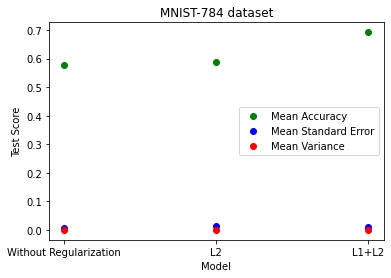

In [1]:
import numpy as np
import matplotlib.pyplot as plt

accuracy_base = np.array([60.37, 56.23, 58.81, 55.41, 58.45, 54.99, 56.86, 61.25, 59.34, 57.56])/100.0
mean_base = np.sum(accuracy_base)/accuracy_base.shape[0]
standard_dev_base = np.sqrt(np.sum((accuracy_base-mean_base)**2)/(accuracy_base.shape[0]-1.0))
standard_error_base = standard_dev_base/np.sqrt(accuracy_base.shape[0])
variance_base = standard_dev_base**2




accuracy_L2 = np.array([65.14, 60.81, 58.98, 59.55, 62.76, 54.91, 52.55, 60.10, 59.83, 52.74])/100.0
mean_L1 = np.sum(accuracy_L2)/accuracy_L2.shape[0]
standard_dev_L1 = np.sqrt(np.sum((accuracy_L2-mean_L1)**2)/(accuracy_L2.shape[0]-1.0))
standard_error_L1 = standard_dev_L1/np.sqrt(accuracy_L2.shape[0])
variance_L1 = standard_dev_L1**2

accuracy_L1_L2 = np.array([65.21, 72.35, 67.62, 66.87, 70.47, 74.53, 69.56, 71.95, 64.33, 69.49])/100.0
mean_L2 = np.sum(accuracy_L1_L2)/accuracy_L1_L2.shape[0]
standard_dev_L2 = np.sqrt(np.sum((accuracy_L1_L2-mean_L2)**2)/(accuracy_L1_L2.shape[0]-1.0))
standard_error_L2 = standard_dev_L2/np.sqrt(accuracy_L1_L2.shape[0])
variance_L2 = standard_dev_L2**2


x = np.array([0,1,2])
y_mean = np.array([mean_base, mean_L1, mean_L2])
y_standard_error = np.array([standard_error_base, standard_error_L1, standard_error_L2])
y_variance = np.array([variance_base, variance_L1, variance_L2])

plt.figure(0)
my_xticks = ['Without Regularization','L2','L1+L2']
plt.plot(x, y_mean, 'go', label='Mean Accuracy')
plt.plot(x, y_standard_error, 'bo', label='Mean Standard Error')
plt.plot(x, y_variance, 'ro', label='Mean Variance')
plt.xticks(x, my_xticks)
plt.xlabel('Model')
plt.ylabel('Test Score')
plt.title('MNIST-784 dataset')
plt.legend()
plt.savefig('plot.jpg',dpi=200)

In [2]:
acct = [65.14, 60.81, 58.98, 59.55, 62.76, 54.91, 52.55, 60.10, 59.83, 52.74]

In [4]:
acct = [65.21, 72.35, 67.62, 66.87, 70.47, 74.53, 69.56, 71.95, 64.33, 69.49]

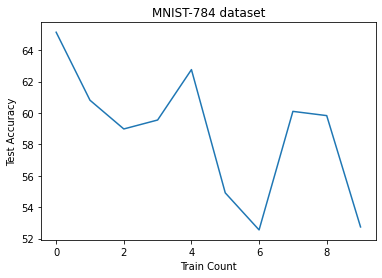

In [3]:
?from matplotlib import pyplot as plt
plt.xlabel('Train Count')
plt.ylabel('Test Accuracy')
plt.title('MNIST-784 dataset')
plt.plot(acct)
# plt.plot(loss)

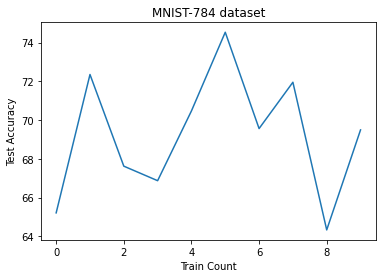

In [5]:
from matplotlib import pyplot as plt
plt.xlabel('Train Count')
plt.ylabel('Test Accuracy')
plt.title('MNIST-784 dataset')
plt.plot(acct)
# plt.plot(loss)